In [16]:
import numpy as np
import pandas as pd
import overpy
import geopandas as gpd
import ee
from geetools import batch
import requests
from shapely.geometry import Polygon, box
import os
import rasterio
import rasterio.plot
import matplotlib.pyplot as plt

## OpenStreetMap API

In [2]:
api = overpy.Overpass()

# Fetch all wastewater treatment plants within California's boundary
query = f"""
    area[admin_level=4]["name"="California"]->.searchArea;
    (
      way["man_made"="wastewater_plant"](area.searchArea);
    );
    (._;>;);
    out body;
    """

result = api.query(query)

# Store results in desired format
plants = {}

for way in result.ways:
    # Use the name of the plant or its ID if the name is not available
    plant_name = way.tags.get("name", f"Plant_{way.id}")

    # Extract nodes lat and lon without id
    nodes_coords = [(node.lon, node.lat) for node in way.nodes]

    # get rid of "Decimal"  in the coordinates
    nodes_coords = [tuple(map(float, i)) for i in nodes_coords]
    
    plants[plant_name] = nodes_coords


In [3]:
# print the first 5 plants
for key, value in list(plants.items())[:5]:
    print(key, value)

Plant_24298754 [(-121.8093956, 37.6930507), (-121.805817, 37.6930115), (-121.8056706, 37.6930099), (-121.8056706, 37.6904833), (-121.8058937, 37.6899807), (-121.8059778, 37.6894001), (-121.8060333, 37.6892735), (-121.8061508, 37.6892261), (-121.8071187, 37.6892498), (-121.8095244, 37.6896004), (-121.8096322, 37.6904367), (-121.809724, 37.6914042), (-121.8097223, 37.6915312), (-121.809522, 37.6915461), (-121.8093956, 37.6930507)]
Plant_24396910 [(-121.7836023, 36.8042341), (-121.7836343, 36.8037659), (-121.7833675, 36.8022232), (-121.7828697, 36.7990947), (-121.782329, 36.7983538), (-121.7828526, 36.7974329), (-121.7828135, 36.7971656), (-121.7827041, 36.7968984), (-121.7821745, 36.7964432), (-121.7809986, 36.7959414), (-121.7799, 36.7950548), (-121.7790588, 36.795261), (-121.7784065, 36.796072), (-121.7771877, 36.7992885), (-121.7776512, 36.8002576), (-121.7762693, 36.800938), (-121.7764839, 36.8015634), (-121.7779087, 36.8024362), (-121.7778655, 36.8026007), (-121.7777709, 36.8029603)

In [4]:
plants_with_official_name = {key: value for key, value in plants.items() if not key.startswith("Plant_")}
print(f"Number of official plants: {len(plants_with_official_name)}")

Number of official plants: 214


In [5]:
geoms = [Polygon(plants[key]) for key in plants]
df = gpd.GeoDataFrame({'WWTP_name': list(plants.keys()), 'geometry': geoms}, crs="EPSG:4326")
df

,WWTP_name,geometry
0,Plant_24298754,"POLYGON ((-121.80940 37.69305, -121.80582 37.6..."
1,Plant_24396910,"POLYGON ((-121.78360 36.80423, -121.78363 36.8..."
2,EBMUD Wastewater Treatment Plant,"POLYGON ((-122.29310 37.82285, -122.29238 37.8..."
3,Hyperion Wastewater Treatment Plant,"POLYGON ((-118.42914 33.91957, -118.43162 33.9..."
4,San José–Santa Clara Regional Wastewater Facility,"POLYGON ((-121.95539 37.43062, -121.95452 37.4..."
...,...,...
3101,Plant_1188491467,"POLYGON ((-121.52373 38.56623, -121.52238 38.5..."
3102,Plant_1201733978,"POLYGON ((-118.94698 37.64148, -118.94744 37.6..."
3103,Plant_1205552620,"POLYGON ((-121.96382 38.68125, -121.96450 38.6..."
3104,Plant_1213883271,"POLYGON ((-120.46290 38.12344, -120.46263 38.1..."


In [6]:
geoms_official_name = [Polygon(plants_with_official_name[key]) for key in plants_with_official_name]
df_official_name = gpd.GeoDataFrame({'WWTP_name': list(plants_with_official_name.keys()), 'geometry': geoms_official_name}, crs="EPSG:4326")
df_official_name

,WWTP_name,geometry
0,EBMUD Wastewater Treatment Plant,"POLYGON ((-122.29310 37.82285, -122.29238 37.8..."
1,Hyperion Wastewater Treatment Plant,"POLYGON ((-118.42914 33.91957, -118.43162 33.9..."
2,San José–Santa Clara Regional Wastewater Facility,"POLYGON ((-121.95539 37.43062, -121.95452 37.4..."
3,Sunnyvale Water Pollution Control Plant,"POLYGON ((-122.01815 37.41911, -122.01795 37.4..."
4,Burlingame Wastewater Treatment Plant,"POLYGON ((-122.35803 37.59173, -122.35745 37.5..."
...,...,...
209,County Club Wastewater Treatment Plant,"POLYGON ((-120.63039 35.21489, -120.63032 35.2..."
210,Riverside Water Quality Control Plant,"POLYGON ((-117.46432 33.96161, -117.46434 33.9..."
211,West County Wastewater - Water Quality & Resou...,"POLYGON ((-122.38026 37.96765, -122.38023 37.9..."
212,Jackson Rancheria Casino Resort Waste Water Plant,"POLYGON ((-120.73121 38.38433, -120.73104 38.3..."


## Google Earth Engine

How to authenticate: https://developers.google.com/earth-engine/guides/python_install#authentication

In [7]:
ee.Authenticate()


Successfully saved authorization token.


In [8]:
ee.Initialize()

In [9]:
df['geometry'].bounds

,minx,miny,maxx,maxy
0,-121.809724,37.689226,-121.805671,37.693051
1,-121.783634,36.795055,-121.776269,36.804234
2,-122.299808,37.822834,-122.291656,37.827277
3,-118.434659,33.919567,-118.425820,33.930754
4,-121.955388,37.428288,-121.940809,37.435635
...,...,...,...,...
3101,-121.523730,38.561855,-121.521200,38.566228
3102,-118.947438,37.637012,-118.942315,37.642072
3103,-121.964497,38.678236,-121.961699,38.681255
3104,-120.462942,38.122868,-120.458940,38.127729


NAIP dataset in Googel Earth Engine: https://developers.google.com/earth-engine/datasets/catalog/USDA_NAIP_DOQQ

ee.Geometry.Rectangle: https://github.com/gee-community/example-scripts/blob/master/Geometries/ee.Geometry.Rectangle.md

In [10]:
df_not_download = df.copy() # keep track of which plants have NOT been downloaded

In [11]:
# read in csv file that contains the names of the plants that have NOT been downloaded
# df_download = pd.read_csv("../30_result/trouble_download.csv")

In [55]:
# Create a directory to save images
download_directory = "../30_result/downloaded_images/"
if not os.path.exists(download_directory):
    os.mkdir(download_directory)
    
# Iterate over each wastewater treatment plant and fetch its image
for idx, row in df_not_download.iterrows():
    # 1. Get the bounding box for the current wastewater treatment plant
    bbox = row.geometry.bounds
    
    # 2. Determine the length and height of the WWTP and double them
    length = 2 * (bbox[2] - bbox[0])
    height = 2 * (bbox[3] - bbox[1])
    center_x = (bbox[0] + bbox[2]) / 2
    center_y = (bbox[1] + bbox[3]) / 2
    
    # Define the region of interest using the center and transformed dimensions
    roi = ee.Geometry.Rectangle([center_x - length / 2.5, \
                                center_y - height / 2.5, \
                                center_x + length / 2.5, \
                                center_y + height / 2.5])
    collection = ee.ImageCollection('USDA/NAIP/DOQQ') \
        .filterBounds(roi) \
        .filterDate(ee.Date('2020-01-01'), ee.Date('2023-01-01')) 
    
    # Get the first image from the collection
    image = collection.first().clip(roi)
    
    # Generate a thumbnail URL for the visualization
    try:
        url = image.getThumbURL({
            'bands': ['R', 'G', 'B'],
            'region': roi,
            'format': 'png',  # or 'jpeg'
            'max': 255,
            'min': 0
        })
    
        print(f"Download URL for {row['WWTP_name']}: {url}")
    
    except Exception as e:
        print(f"Failed to get image for {row['WWTP_name']}. Error: {e}")
        continue

    # Download the image
    try:
        response = requests.get(url)
    except Exception as e:
        # if response.status_code != 200:
        print(f"Failed to download image for {row['WWTP_name']}. Received status code: {response.status_code}")
        continue

    try:
        if 'image' in response.headers['Content-Type']:
            with open(os.path.join(download_directory, f"{row['WWTP_name']}.jpg"), 'wb') as file:  # Changing extension to jpg
                file.write(response.content)
            print(f"Downloaded image for {row['WWTP_name']}.")
            # delete the row in the dataframe
            df_not_download.drop(idx, inplace=True)
        else:
            print(f"Failed to download image for {row['WWTP_name']}. Received content: {response.text}")
    except Exception as e:
        print(f"Failed to download image for {row['WWTP_name']}. Error: {e}")
        continue

    # Export to Google Drive
    # task = ee.batch.Export.image.toDrive(
    #     image=image,
    #     description=row['WWTP_name'],
    #     folder="EE_images",
    #     fileNamePrefix=row['WWTP_name'] + "_image",
    #     region=roi.getInfo()["coordinates"],
    #     scale=1,  # You can adjust the scale (resolution) as needed
    #     fileFormat="GeoTIFF",
    #     maxPixels=1e13
    # )
    # task.start()

    # if idx == 19:
    #     break

Download URL for Plant_24298754: https://earthengine.googleapis.com/v1/projects/earthengine-legacy/thumbnails/5c9850caecfa35464250f62ebe863980-397f059faa525ccab7be6ea0d309164c:getPixels
Downloaded image for Plant_24298754.
Download URL for Plant_24396910: https://earthengine.googleapis.com/v1/projects/earthengine-legacy/thumbnails/597c2cf26b4e2a48f3a4de2de1296a19-07cd1dbdad83004d523af5314f22b558:getPixels
Downloaded image for Plant_24396910.
Download URL for EBMUD Wastewater Treatment Plant: https://earthengine.googleapis.com/v1/projects/earthengine-legacy/thumbnails/20e170ef8e7186b360115adfe6bcfe29-73209e117a2284ae81a26f726ac1ccbd:getPixels
Downloaded image for EBMUD Wastewater Treatment Plant.
Download URL for Hyperion Wastewater Treatment Plant: https://earthengine.googleapis.com/v1/projects/earthengine-legacy/thumbnails/304c0246b277e7cda36996b00ce10313-154846c311c0127b503a576126eee013:getPixels
Downloaded image for Hyperion Wastewater Treatment Plant.
Download URL for San José–Sant

In [56]:
df_not_download.shape

(40, 2)

In [57]:
df.shape

(3104, 2)

In [58]:
df_not_download.to_csv("../30_result/trouble_download.csv", index=False)

In [59]:
df.to_csv("../30_result/3k_WWTP_List.csv", index=False)

**Download the filtered 214 satellite images**

In [11]:
# Create a directory to save images
download_directory = "../30_result/filtered_images/"
if not os.path.exists(download_directory):
    os.mkdir(download_directory)
    
# Iterate over each wastewater treatment plant and fetch its image
for idx, row in df_official_name.iterrows():
    # 1. Get the bounding box for the current wastewater treatment plant
    bbox = row.geometry.bounds
    
    # 2. Determine the length and height of the WWTP and double them
    length = 2 * (bbox[2] - bbox[0])
    height = 2 * (bbox[3] - bbox[1])
    center_x = (bbox[0] + bbox[2]) / 2
    center_y = (bbox[1] + bbox[3]) / 2
    
    # Define the region of interest using the center and transformed dimensions
    roi = ee.Geometry.Rectangle([center_x - length / 2.5, \
                                center_y - height / 2.5, \
                                center_x + length / 2.5, \
                                center_y + height / 2.5])
    collection = ee.ImageCollection('USDA/NAIP/DOQQ') \
        .filterBounds(roi) \
        .filterDate(ee.Date('2020-01-01'), ee.Date('2023-01-01')) 
    
    # Get the first image from the collection
    image = collection.first().clip(roi)
    
    # Generate a thumbnail URL for the visualization
    try:
        url = image.getThumbURL({
            'bands': ['R', 'G', 'B'],
            'region': roi,
            'format': 'png',  # or 'jpeg'
            'max': 255,
            'min': 0
        })
    
        print(f"Download URL for {row['WWTP_name']}: {url}")
    
    except Exception as e:
        print(f"Failed to get image for {row['WWTP_name']}. Error: {e}")
        continue

    # Download the image
    try:
        response = requests.get(url)
    except Exception as e:
        # if response.status_code != 200:
        print(f"Failed to download image for {row['WWTP_name']}. Received status code: {response.status_code}")
        continue

    try:
        if 'image' in response.headers['Content-Type']:
            with open(os.path.join(download_directory, f"{row['WWTP_name']}.jpg"), 'wb') as file:  # Changing extension to jpg
                file.write(response.content)
            print(f"Downloaded image for {row['WWTP_name']}.")
            # delete the row in the dataframe
            df_not_download.drop(idx, inplace=True)
        else:
            print(f"Failed to download image for {row['WWTP_name']}. Received content: {response.text}")
    except Exception as e:
        print(f"Failed to download image for {row['WWTP_name']}. Error: {e}")
        continue

    # Export to Google Drive
    # task = ee.batch.Export.image.toDrive(
    #     image=image,
    #     description=row['WWTP_name'],
    #     folder="EE_images",
    #     fileNamePrefix=row['WWTP_name'] + "_image",
    #     region=roi.getInfo()["coordinates"],
    #     scale=1,  # You can adjust the scale (resolution) as needed
    #     fileFormat="GeoTIFF",
    #     maxPixels=1e13
    # )
    # task.start()

    # if idx == 19:
    #     break

Download URL for EBMUD Wastewater Treatment Plant: https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/20e170ef8e7186b360115adfe6bcfe29-c492d68a2660039995f3068bfb8d4f33:getPixels
Downloaded image for EBMUD Wastewater Treatment Plant.
Download URL for Hyperion Wastewater Treatment Plant: https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/304c0246b277e7cda36996b00ce10313-8d18d28433371067af487372fb0d0942:getPixels
Downloaded image for Hyperion Wastewater Treatment Plant.
Download URL for San José–Santa Clara Regional Wastewater Facility: https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/71ed943d5acc6f50e8cfb890b7183445-3a9aaee60d36f4d8affa1164cd438372:getPixels
Downloaded image for San José–Santa Clara Regional Wastewater Facility.
Download URL for Sunnyvale Water Pollution Control Plant: https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ea048099db83dc333ee1dc0af81c

31 failed

In [12]:
# find the largest bounding box
max_length = 0
max_height = 0
for i in range(len(df)):
    bbox = df.iloc[i].geometry.bounds
    length = bbox[2] - bbox[0]
    height = bbox[3] - bbox[1]
    if length > max_length:
        max_length = length
        print(df['WWTP_name'][i])
    if height > max_height:
        max_height = height
        print(df['WWTP_name'][i])
print(max_length, max_height)

Plant_24298754
Plant_24298754
Plant_24396910
Plant_24396910
EBMUD Wastewater Treatment Plant
Hyperion Wastewater Treatment Plant
Hyperion Wastewater Treatment Plant
San José–Santa Clara Regional Wastewater Facility
Wastewater Treatment Plant
Wastewater Treatment Plant
Fresno Clovis Regional Waste Water Treatment Plant
Fresno Clovis Regional Waste Water Treatment Plant
0.04514260000000547 0.02880500000000552


In [13]:
df.loc[:,'length'] = df.loc[:,'geometry'].bounds.maxx - df.loc[:,'geometry'].bounds.minx
df.loc[:, 'height'] = df.loc[:,'geometry'].bounds.maxy - df.loc[:,'geometry'].bounds.miny
df.head()

,WWTP_name,geometry,length,height
0,Plant_24298754,"POLYGON ((-121.80940 37.69305, -121.80582 37.6...",0.004053,0.003825
1,Plant_24396910,"POLYGON ((-121.78360 36.80423, -121.78363 36.8...",0.007365,0.009179
2,EBMUD Wastewater Treatment Plant,"POLYGON ((-122.29310 37.82285, -122.29238 37.8...",0.008151,0.004443
3,Hyperion Wastewater Treatment Plant,"POLYGON ((-118.42914 33.91957, -118.43162 33.9...",0.008840,0.011187
4,San José–Santa Clara Regional Wastewater Facility,"POLYGON ((-121.95539 37.43062, -121.95452 37.4...",0.014579,0.007347


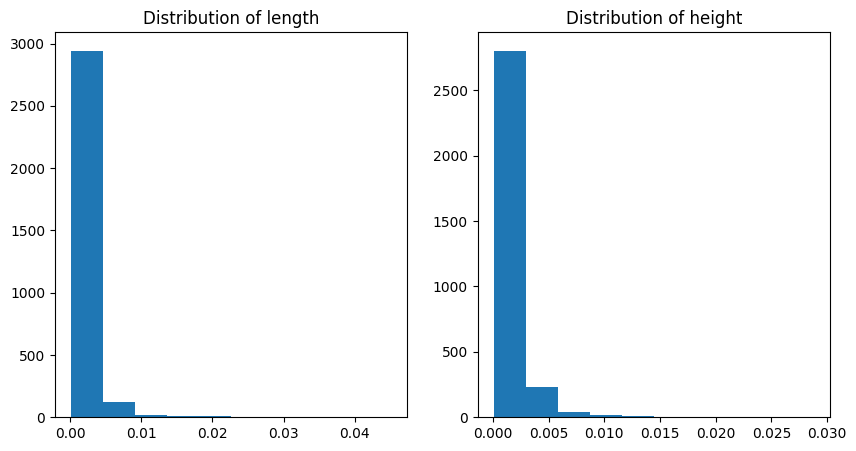

In [14]:
# distribution of length and height
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.hist(df['length'])
plt.title('Distribution of length')

plt.subplot(122)
plt.hist(df['height'])
plt.title('Distribution of height')
plt.show()


choose 0.01x0.01 as dimension

In [15]:
def download_NAIP_toLocal(bbox, savefolder, scale=1):
    """
    downloads NAIP imagery from the specified bounding box
    """
    AOI = ee.Geometry.Rectangle(list(bbox), "EPSG:4326", False)

    collection = (
        ee.ImageCollection("USDA/NAIP/DOQQ")
        .filterDate("2018-01-01", "2019-01-01")
        .filterBounds(AOI)
        .select(['R', 'G', 'B', 'N'])
    )

    image = ee.Image(collection.mosaic()).clip(AOI)
    batch.image.toLocal(image, savefolder, scale=scale, region=AOI)

def stack_bands(name, outname):
    file_list = [name + '.R.tif', name + '.G.tif', name + '.B.tif', name + '.N.tif']

    # Read metadata of first file
    with rasterio.open(file_list[0]) as src0:
        meta = src0.meta

    # Update meta to reflect the number of layers
    meta.update(count = len(file_list))

    # Read each layer and write it to stack
    with rasterio.open(outname, 'w', **meta) as dst:
        for id, layer in enumerate(file_list, start=1):
            with rasterio.open(layer) as src1:
                dst.write_band(id, src1.read(1))

def download_naip(bbox,savefolder,savefilename):
    download_NAIP_toLocal(bbox, savefolder, scale=1)
    stack_bands(savefolder +'/download',savefilename)

In [25]:
os.chdir('/workspaces/solar_wastewater/30_result')
downloaded_directory = "downloaded_images_2"
if not os.path.exists(downloaded_directory):
    os.mkdir(downloaded_directory)

for idx, row in df.iterrows():
    # 1. Get the bounding box for the current wastewater treatment plant
    bbox = row.geometry.bounds
    
    # 2. Determine the length and height of the WWTP and double them
    length = 0.01
    height = 0.01
    center_x = (bbox[0] + bbox[2]) / 2
    center_y = (bbox[1] + bbox[3]) / 2
    
    # Define the region of interest using the center and transformed dimensions
    bbox = [center_x - length / 2, \
            center_y - height / 2, \
            center_x + length / 2, \
            center_y + height / 2]
    download_naip(bbox,downloaded_directory,os.path.join(downloaded_directory, f"{row['WWTP_name']}.tif"))

    if idx == 9:
        break

download time:\
0.02x0.02: 14min\
0.01x0.01: 6min

## Plot bounding box on top of satellite image

In [28]:
with rasterio.open('downloaded_images_2/EBMUD Wastewater Treatment Plant.tif') as src:
    # Read the image data
    img = src.read([1, 2, 3, 4])  # Reads the first three bands for RGB

df_EBMUD = df[df['WWTP_name'] == 'EBMUD Wastewater Treatment Plant']

# check 
# Raster extent
left, bottom, right, top = src.bounds
print("Raster bounds:", left, bottom, right, top)

# Bounding box extent
minx, miny, maxx, maxy = df_EBMUD.geometry.total_bounds
print("Bounding box bounds:", minx, miny, maxx, maxy)

# raster geometry system
print("Raster CRS:", src.crs)

# bounding box geometry system
print("Bounding box CRS:", df_EBMUD.crs)

Raster bounds: -122.30073909772723 37.82005262509154 -122.29073186546213 37.83005985735663
Bounding box bounds: -122.2998075 37.8228337 -122.2916564 37.8272765
Raster CRS: EPSG:4326
Bounding box CRS: EPSG:4326


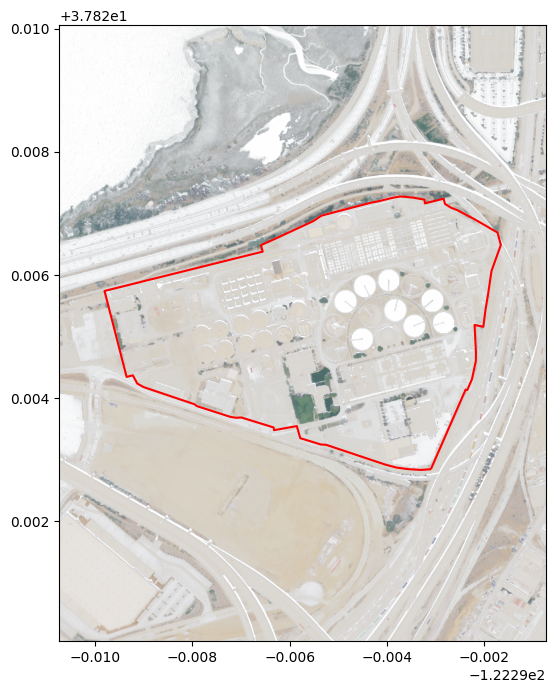

In [33]:
fig, ax = plt.subplots(figsize=(8,8))

# Plot the raster
ax = rasterio.plot.show(img, ax=ax, transform=src.transform)

# Plot the bounding box
df_EBMUD.boundary.plot(ax=ax, color='red', linewidth=1.5)

plt.show()